### Script pour le controle des données brutes issues de la chaine INSIGHT
### Etude de conformité des fichiers

In [2]:
%%writefile ".env"

PROJECT_ID="feux_cq"

COMMUN_PATH = "N:/"
PATH_INFOCENTRE_APP = ${COMMUN_PATH}Informatique/SIG/Application/Jupyterhub/
PATH_ETUDE = ${COMMUN_PATH}Informatique/SIG/Donnees/Oeil/Traitement_Donnees/SURFACES_BRULEES_SENTINEL/2022/220502_PreparationFeu2020/
PROJECT_PATH =${COMMUN_PATH}Informatique/SIG/Etudes/2023/2309_QC_feux/Travail/Scripts/
DATA_CATALOG_DIR = ${PATH_INFOCENTRE_APP}projets/catalogFiles/ 
DATA_OUTPUT_DIR = ${PROJECT_PATH}output/
SIG_DATA_PATH = ${COMMUN_PATH}Informatique/SIG/Donnees/
DB_USER="jfnguyenvansoc"
DB_PWD="oeil"
DB_HOST=172.20.12.13
DB_PORT=5432

DB_WORKSPACE="oeil_traitement"
DB_REF="oeil_reference"
DB_EXT="data_externe"
DB_SCHEMA = "feux_cq"
DB_SCHEMA_REF = "carto"

Overwriting .env


In [3]:
import logging
from filecmp import dircmp
from os import listdir
import os
import filecmp
from dotenv import load_dotenv
from intake import open_catalog
import matplotlib as plt
import pandas as pd
import numpy as np
from shapely import wkt
import shapely
from sqlalchemy import create_engine
from shapely.geometry import shape
from shapely.ops import unary_union
from geopandas import GeoDataFrame
import geopandas as gpd
from datetime import datetime

load_dotenv()

## Create log file 
logging.basicConfig(filename='N:/Informatique/SIG/Etudes/2023/2309_QC_feux/Travail/Scripts/Controle_data/log_Controle_data_brute.log',filemode='w', encoding='utf-8', level=logging.INFO, force=True, format='%(message)s')

##open yaml file to get raw buned area table
catfeux = open_catalog(f'{os.getenv("PROJECT_PATH")}catalogFiles/Fire_Detection_Data_Quality.yaml')

surfdetect_control = catfeux.Surfaces_brulees_brute_control.read()

date_start=pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_end=pd.to_datetime("2023-12-31", format="%Y-%m-%d")

#date_start=datetime.strptime("2023-01-01","%Y-%m-%d") 
#date_end=datetime.strptime("2023-10-31","%Y-%m-%d")

## Début des contrôles

### Check if tile's name are differents than the 15 use in NC

In [4]:
## Check if tile's name are differents than the 15 use in NC
logging.info('------------------------------------------------')
logging.info('Check if unknown tiles are found in data')
logging.info('------------------------------------------------')

## liste des 15 tuiles présentes sur la GT et les iles 
list_tiles=['L2A_T58KCC','L2A_T58KCD','L2A_T58KDB','L2A_T58KDC','L2A_T58KEA','L2A_T58KEB','L2A_T58KEC',
            'L2A_T58KFA','L2A_T58KFB','L2A_T58KFC','L2A_T58KGA','L2A_T58KGB','L2A_T58KGC','L2A_T58KGV','L2A_T58KHB']

## prendre que le numéro de la dalle pour les traitements
surfdetect_control['nom'] = [x[-10:] for x in surfdetect_control['nom']]

error_tile=[]

for i in range(len(surfdetect_control)):
    if surfdetect_control['nom'][i] in list_tiles:
         continue
    else:
        error_tile.append(surfdetect_control.iloc[i]) ## on regarde si d'autres tuiles sont présentes dans le jeu de donnée

if not error_tile:
    print('empty_list')
    logging.info('Not unkonw tiles found in data - continue process')
else:
    error_tile=pd.concat(error_tile,axis=1, ignore_index=True).T
    print('list if not empty')
    logging.error('%s !! WARNING !! Unknow tile found in data - check ogc_fid number above or in code !! :', error_tile['ogc_fid']) ## on alimente le log si présence de tuiles autres

empty_list


### Check if tile occurence is equal to zero

In [5]:
### Check if tile occurence is equal to zero
## traitement à prendre avec des pincettes car selon la résolution temporelle des données des tuiles peuvent manquer 

logging.info('------------------------------------------------')
logging.info('Check if tile occurence is set to 0')
logging.info('------------------------------------------------')

df_dalle=pd.DataFrame({"date":surfdetect_control.date,"dalle_names":surfdetect_control.nom})
## prendre que le numéro de la dalle
df_dalle['dalle_names'] = [x[-10:] for x in df_dalle['dalle_names']]
df_dalle=df_dalle.set_index(df_dalle['date'])
df_dalle = df_dalle.sort_index()

occurrences_dalles = df_dalle["dalle_names"].value_counts()
print(occurrences_dalles)

values_at_zero = occurrences_dalles[occurrences_dalles == 0].index

if not values_at_zero.empty:
    logging.error('%s !! WARNING !! Tile occurence is set to 0 - check tile name above or in code !! :', values_at_zero)
    print(values_at_zero)
else:
    logging.info('Tile occurence is different than 0 in data - continue process')

L2A_T58KEB    8180
L2A_T58KDC    7496
L2A_T58KDB    4523
L2A_T58KFA    2366
L2A_T58KFB    2196
L2A_T58KEA    1845
L2A_T58KCC     708
L2A_T58KEC     622
L2A_T58KCD     595
L2A_T58KGB     365
L2A_T58KHB     171
L2A_T58KGA      79
L2A_T58KGV      45
L2A_T58KGC      23
L2A_T58KFC      17
Name: dalle_names, dtype: int64


### Check if burned area are under 1ha

In [6]:
## Check if burned area are under 1ha

logging.info('------------------------------------------------')
logging.info('Check if burned areas are not under 1 ha')
logging.info('------------------------------------------------')

error_surface=[]

for i in range(len(surfdetect_control)):
    if surfdetect_control['surface'][i] >= 1:
         continue
    else:
        error_surface.append(surfdetect_control.iloc[i])

if not error_surface:
    print('empty_list')
    logging.info('No surface found under 1ha - continue process')
else:
    error_surface=pd.concat(error_surface,axis=1, ignore_index=True).T
    print('list if not empty')
    logging.error('%s !! WARNING !! burned areas are found under 1 ha - check ogc_fid number above or in code !! :', error_surface['ogc_fid'])

empty_list


### Check if geometries have errors

In [7]:
## Check if burned area have wrong geometries

logging.info('------------------------------------------------')
logging.info('Check if burned areas have wrong geometries')
logging.info('------------------------------------------------')

is_valid = surfdetect_control.geometry.is_valid
invalid_geometries = surfdetect_control[~is_valid]

print("Multipolygones with geometries errors :",invalid_geometries)
logging.error('%s !! WARNING !! burned areas geometries have errors - check ogc_fid number above or in code !! :', invalid_geometries.index)

surfdetect_control.geometry = surfdetect_control.geometry.buffer(0) # correct the geometry

## check if the correction is applied
is_valid_after_correction = surfdetect_control.geometry.is_valid
invalid_geometries_after_correction = surfdetect_control[~is_valid_after_correction]
print("Check if geometry correction were applied :", invalid_geometries_after_correction)
logging.error('%s !! WARNING !! a geometry correction were applied - if empty continue process : ',invalid_geometries_after_correction)

Multipolygones with geometries errors :            date         nom       province      commune     surface       x  \
143    20230103  L2A_T58KEA   Province Sud   BOULOUPARI    2.851135  395009   
1810   20230222  L2A_T58KEB  Province Nord  PONERIHOUEN   40.052257  350736   
3667   20230503  L2A_T58KEB  Province Nord      KOUAOUA   13.105738  375637   
3809   20230503  L2A_T58KEB  Province Nord      KOUAOUA   13.105738  375637   
14188  20230730  L2A_T58KEB  Province Nord    POUEMBOUT    1.641048  300666   
14957  20230730  L2A_T58KEB  Province Nord    POUEMBOUT    1.641048  300666   
15466  20230801  L2A_T58KEB  Province Nord      KOUAOUA   19.328628  373741   
16385  20230806  L2A_T58KEC  Province Nord        TOUHO   20.064885  315581   
17458  20230811  L2A_T58KEB  Province Nord     HOUAILOU    6.142776  374116   
18738  20230814  L2A_T58KCD  Province Nord        BELEP    5.195726  155790   
18815  20230814  L2A_T58KDB  Province Nord          VOH    6.464216  249534   
19366  20230

#### Check if burned areas are detected outside date interval set at the begening

In [8]:
## Check if burned areas are detected outside date interval set at the begening

logging.info('------------------------------------------------')
logging.info('%s Check if burned areas are included into the following date interval', )
logging.info('------------------------------------------------')

error_date=[]

for i in range(len(surfdetect_control)):
    current_date = pd.to_datetime(surfdetect_control['date'][i])
    
    if date_start <= current_date <= date_end:
        continue
    else:
        error_date.append(surfdetect_control.iloc[i])

if not error_date:
    print('empty_list')
    logging.info('Burned areas are included into date range - continue process')
else:
    error_date=pd.concat(error_date,axis=1, ignore_index=True).T
    print('list if not empty')
    logging.error('%s !! WARNING !! burned areas are found outside date range - check ogc_fid number above or in code !! :', error_date['ogc_fid'])

empty_list


In [9]:
## create an id
surfdetect_control['ID'] = range(1, len(surfdetect_control)+1,1)

### Check if identical geometries are observed at a same date

In [10]:
#check if identical geometries are observed at a same date

def compare_geometries(gdf):
    geometry_date_dict = {}

    for index, row in gdf.iterrows():
        geometry =  row['geometry']
        date = row['date']

        # Convertir la géométrie en une forme Shapely
        geom_shape = shape(geometry)
        key = (geom_shape, date)

        # Ajouter la paire (forme, date) au dictionnaire
        if key not in geometry_date_dict:
            geometry_date_dict[key] = []

        geometry_date_dict[key].append(index)
    identique_geom=[]
    
    # identifier les géométries avec la même forme à la même date = doublon
    for key, indices in geometry_date_dict.items():
        if len(indices) > 1:
            identique_geom.append(indices)
            print(f"Géométries identiques à la même date : {indices}")
    
    return(identique_geom)

surfdetect_control['geometry']=shapely.wkt.loads(shapely.wkt.dumps(surfdetect_control['geometry'], rounding_precision=1)) ## change number of decimal for geometry
identique_geom=compare_geometries(surfdetect_control) 
print(identique_geom)

logging.info('------------------------------------------------')
logging.info('%s Check if 2 identical geometries shape are observed at a same date', )
logging.info('------------------------------------------------')

if not identique_geom:
    print('empty_list')
    logging.info('NO identical geometries found at the same date - continue process')
else:
    print('list if not empty')
    #logging.error('%s !! WARNING !! same geometries at a same date were found - check ogc_fid number above or in code !! :', identique_geom.index)
    
    ### if identical geometries are found : check if they have the name tile name
    for sublist in identique_geom:
        nom_values = [surfdetect_control.loc[i, 'nom'] for i in sublist]
        index_values=[surfdetect_control.loc[i, 'ID'] for i in sublist]
        if all(value == nom_values[0] for value in nom_values):
            print('nom de thuile identique')
            logging.error('%s !! WARNING !! same geometries at a same date were found on a same tile: check above for informations',index_values)
            
            ## we keep the first geom et delete the others
            if len(sublist) == 2: 
                surfdetect_control=surfdetect_control.drop(sublist[1])
                print('delete index : ',sublist[1])
            else:
                surfdetect_control=surfdetect_control.drop(sublist[1:])
                print('delete index :',sublist[1:])
        else:
            print('nom de thuile différente')
            logging.error('%s !! WARNING !! same geometries at a same date were found on different tiles : check above for informations',index_values)
            
            ## we keep the first geom et delete the others
            if len(sublist) == 2: 
                surfdetect_control=surfdetect_control.drop(sublist[1])
                print('delete index : ',sublist[1])
            else:
                surfdetect_control=surfdetect_control.drop(sublist[1:])
                print('delete index :',sublist[1:])

surfdetect_control=surfdetect_control.reset_index(drop=True)
surfdetect_control['ID'] = range(1, len(surfdetect_control)+1,1)

Géométries identiques à la même date : [2280, 2387]
Géométries identiques à la même date : [2281, 2386]
Géométries identiques à la même date : [2282, 2385]
Géométries identiques à la même date : [2283, 2355]
Géométries identiques à la même date : [2284, 2384]
Géométries identiques à la même date : [2285, 2383]
Géométries identiques à la même date : [2286, 2382]
Géométries identiques à la même date : [2287, 2379]
Géométries identiques à la même date : [2288, 2374]
Géométries identiques à la même date : [2289, 2375]
Géométries identiques à la même date : [2290, 2376]
Géométries identiques à la même date : [2291, 2381]
Géométries identiques à la même date : [2292, 2377]
Géométries identiques à la même date : [2293, 2388]
Géométries identiques à la même date : [2294, 2378]
Géométries identiques à la même date : [2295, 2380]
Géométries identiques à la même date : [2296, 2373]
Géométries identiques à la même date : [2297, 2391]
Géométries identiques à la même date : [2298, 2371]
Géométries i

## Overlapping polygons for a same date

In [11]:
def find_intersecting_id(row, gdf):
    same_date_gdf = gdf[gdf['date'] == row['date']]
    
    # Trouver les identifiants des polygones s'intersectant avec le polygone actuel
    intersecting_ids = same_date_gdf[same_date_gdf.geometry.overlaps(row['geometry'])]['ID'].tolist()
    intersecting_ids = [id_ for id_ in intersecting_ids if id_ != row['ID']]
    
    return intersecting_ids

surfdetect_control['Intersecting_ID'] = surfdetect_control.apply(lambda row: find_intersecting_id(row, surfdetect_control), axis=1)
surfdetect_control['groupe_id'] = None
groupe_id_counter = 0

# attribuer des groupe_id à tous les polygones 
for index, row in surfdetect_control.iterrows():
    if surfdetect_control.at[index, 'groupe_id'] is None:
        # Attribuer le groupe_id actuel à tous les polygones s'intersectant
        current_group_id = groupe_id_counter
        surfdetect_control.loc[(surfdetect_control['Intersecting_ID'].apply(lambda x: row['ID'] in x)) | (surfdetect_control['ID'] == row['ID']), 'groupe_id'] = current_group_id
        
        groupe_id_counter += 1

### Check if overlapping geometries are around tile's limit

In [12]:
tile_stl2 = catfeux.tile_sentinel2_line_UTM.read() ## ouvirr la table des limites des tuiles Sentinel2
tile_stl2=tile_stl2.set_index(tile_stl2['Name']) ## mettre en index le nom de la tuile

group_ids = surfdetect_control['groupe_id'].unique()

logging.info('------------------------------------------------')
logging.info('%s Check if overlapping geometries at a same date are observed close to tile limits ', )
logging.info('------------------------------------------------')

for group_id in group_ids:
    # Sélectionnez les données pour le groupe en cours
    group_data = surfdetect_control[surfdetect_control['groupe_id'] == group_id]
    group_data['nom']= [x[-5:] for x in group_data['nom']]
    if group_data.shape[0] >= 2 :

        for i in range(len(group_data)):
            if group_data.iloc[i]['geometry'].buffer(20).intersects(tile_stl2['geometry'].loc[group_data.iloc[i]['nom']]):
                print("tile touche",group_data.iloc[i]["ID"]-1)
                surfdetect_control.drop(group_data.iloc[i]["ID"]-1,inplace=True)
                logging.error('%s !! WARNING !! Intersection between geometry and tile limits were found : check above for informations',group_data.iloc[i]["ID"]-1)

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 447
tile touche 495


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 760
tile touche 762
tile touche 761


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 1005


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 1233
tile touche 1372


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 1412


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 1664


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 1753


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 2223
tile touche 2205
tile touche 2240


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 2433


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 2441


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 2910
tile touche 2902


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 2964
tile touche 2965


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 3217


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 3559


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 3855


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 4082


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 4533


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 4744
tile touche 4745


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 4861
tile touche 5003


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 5520


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 5728


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 6320
tile touche 6322


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 6611
tile touche 6450


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 6897


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 6972
tile touche 6974
tile touche 6979


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 7704


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 7831
tile touche 7916


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 8380
tile touche 8385


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 8593


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 9324
tile touche 9319


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 9562


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 9721


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 9961
tile touche 10366
tile touche 10039


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 10686
tile touche 10674
tile touche 10678


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 10513


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 10861
tile touche 10862


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 11300


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 12091
tile touche 12096
tile touche 11587


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 12102
tile touche 12103
tile touche 12174


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 11974


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 12968
tile touche 12962
tile touche 12935
tile touche 12930
tile touche 12969


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 13015
tile touche 12883


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 13989
tile touche 14002
tile touche 13987


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 13986
tile touche 13920
tile touche 13992
tile touche 13962


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 13985
tile touche 14198
tile touche 14261


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 14300


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 14689


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 14815
tile touche 14837


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 15512
tile touche 15516
tile touche 15517


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 15902
tile touche 16420


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 15975
tile touche 15983
tile touche 15985
tile touche 15986


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 16848
tile touche 16829
tile touche 16833
tile touche 16849


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 16996


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 16783
tile touche 16786


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 17278
tile touche 17281
tile touche 17282


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 18101
tile touche 18300
tile touche 18294


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 18455
tile touche 18453
tile touche 18454


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 19137
tile touche 19154
tile touche 19136
tile touche 19151


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 19563


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 19634


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 19901


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 20281


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 20377
tile touche 20296
tile touche 20372


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 20545


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 20722


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 20819
tile touche 20861
tile touche 20881


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 20905
tile touche 21822
tile touche 21826
tile touche 21821


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 21828


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 22003


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


tile touche 22184
tile touche 22185
tile touche 22187
tile touche 22190


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 22592
tile touche 22591
tile touche 22640


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

tile touche 22609


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Check if overlapping geometries are from differents tiles

In [13]:
group_ids = surfdetect_control['groupe_id'].unique()

logging.info('------------------------------------------------')
logging.info('%s Check if overlapping geometries at a same date are observed from a same tile ', )
logging.info('------------------------------------------------')

for group_id in group_ids:
    
    group_data = surfdetect_control[surfdetect_control['groupe_id'] == group_id]
    group_data['nom']= [x[-5:] for x in group_data['nom']]
    if group_data.shape[0] >= 2 :
        if all(v == group_data['nom'].iloc[0] for v in group_data['nom']):
            print(f"les noms des tuiles sont identiques.", group_data)
            logging.error('%s !! WARNING !! overlapping geometries at a same date were found on a same tile : check above for informations',group_data)
        
        else: ## we merge geometries overlapping from differents tiles
            print(f"les noms des tuiles sont différents")
            nouveau_polygone = unary_union(group_data['geometry'])
            surfdetect_control.at[group_data.iloc[0]["ID"]-1,'geometry'] = nouveau_polygone
            surfdetect_control.drop(group_data.iloc[1:]["ID"]-1,inplace=True)

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont identiques.           date    nom      province     commune   surface       x       y  \
2469  20230403  58KEA  Province Sud  BOULOUPARI  5.422107  396641  256890   
2470  20230403  58KEA  Province Sud  BOULOUPARI  1.120433  396988  256997   

     cuirasse  cuira_area bdtopo  bdtop_area  \
2469     None         NaN   None         NaN   
2470     None         NaN   None         NaN   

                                                  layer  \
2469  FireDetection_SENTINEL2B_20230403-231236-999_L...   
2470  FireDetection_SENTINEL2B_20230403-231236-999_L...   

                                                   path  \
2469  W:/FEUXV2/RESULTS/F

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont dif

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont dif

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont identiques.           date    nom      province     commune    surface       x       y  \
5856  20230712  58KEA  Province Sud  BOULOUPARI   2.180848  396581  256828   
5857  20230712  58KEA  Province Sud  BOULOUPARI  71.257531  396995  257117   

     cuirasse  cuira_area bdtopo  bdtop_area  \
5856     None         NaN   None         NaN   
5857     None         NaN   None         NaN   

                                                  layer  \
5856  FireDetection_SENTINEL2B_20230712-231238-481_L...   
5857  FireDetection_SENTINEL2B_20230712-231238-481_L...   

                                                   path  \
5856  W:/FEUXV2/RESULTS/FireDetection_SENTINEL2B_202...   
5857  W:/FEUXV2/RESULTS/FireDetecti

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont identiques.            date    nom      province commune    surface       x       y  \
10704  20230806  58KFB  Province Sud    THIO   1.450383  413552  277586   
10706  20230806  58KFB  Province Sud    THIO  11.022916  413354  277926   
10734  20230806  58KFB  Province Sud    THIO   1.370362  413535  277445   

      cuirasse  cuira_area    bdtopo  bdtop_area  \
10704     None         NaN  BORDETAN         7.0   
10706     None         NaN      None         NaN   
10734     None         NaN      None         NaN   

                                                   layer  \
10704  FireDetection_SENTINEL2A_20230806-231220-436_L...   
10706  FireDetection_SENTINEL2A_20230806-2312

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont dif

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont dif

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont identiques.            date    nom       province      commune    surface       x       y  \
20933  20231107  58KDC  Province Nord  KAALA GOMEN   1.240807  236884  376269   
20951  20231107  58KDC  Province Nord  KAALA GOMEN  95.112119  237483  376500   

      cuirasse  cuira_area bdtopo  bdtop_area layer  path  \
20933     None         NaN   None         NaN  None  None   
20951     None         NaN   None         NaN  None  None   

                                                geometry     ID  \
20933  POLYGON ((236928.700 376356.800, 236958.700 37...  20934   
20951  POLYGON ((237321.700 377459.700, 237351.700 37...  20952   

      Intersecting_ID groupe_id  
20933         [20906]     18563  
20951         [20906]     18563  
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tu

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont dif

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont identiques.            date    nom       province      commune     surface       x  \
22203  20231127  58KDC  Province Nord  KAALA GOMEN   13.929074  237958   
22205  20231127  58KDC  Province Nord  KAALA GOMEN  181.769015  238832   

            y cuirasse  cuira_area bdtopo  bdtop_area la

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont différents
les noms des tuiles sont dif

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A

les noms des tuiles sont différents


c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
surfdetect_control=surfdetect_control.reset_index(drop=True)
surfdetect_control['ID'] = range(1, len(surfdetect_control)+1,1)

In [15]:
from shapely.geometry import MultiPolygon

# Vérifier si la géométrie est de type Polygon
for i in range(len(surfdetect_control)):
    if surfdetect_control['geometry'].geom_type[i] == 'Polygon':
        surfdetect_control.at[i, 'geometry'] = MultiPolygon([surfdetect_control['geometry'][i]])
        #print(surfdetect_control)
    else:
        print("La géométrie n'est pas de type Polygon.")

In [16]:
surfdetect_control['surface'] = surfdetect_control['geometry'].area/10000

### Control with cloud cover dynamic : use of STAC Catalog

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter

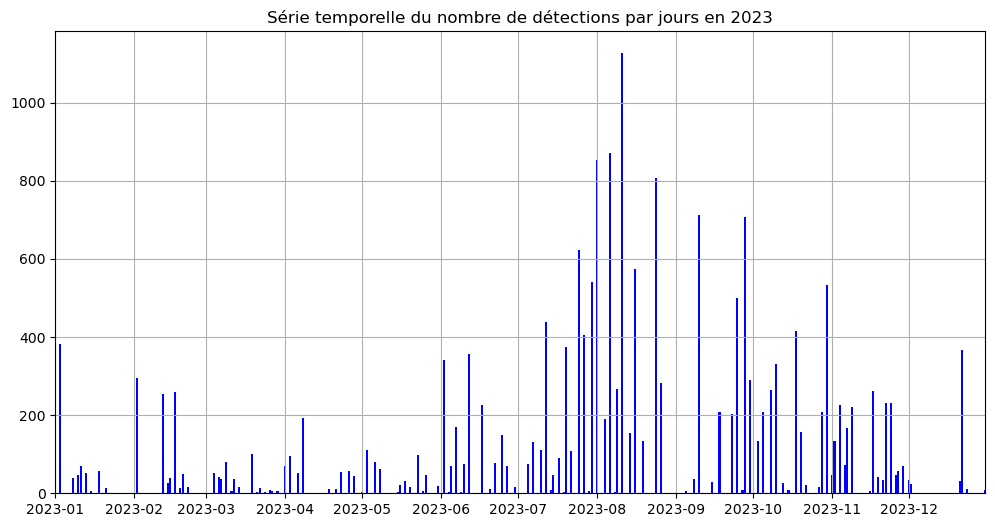

In [18]:
## time serie of burned area detected by day
surfdetect_control['date'] = pd.to_datetime(surfdetect_control['date'])
surfdetect_control=surfdetect_control.set_index(surfdetect_control['date'])

daily_counts = surfdetect_control.resample('D').size()

plt.figure(figsize=(12, 6))
plt.bar(daily_counts.index, daily_counts, color='b')
plt.xlim(date_start,date_end)
plt.title("Série temporelle du nombre de détections par jours en 2023")
plt.grid(True)

### Plot ocurence for each tile

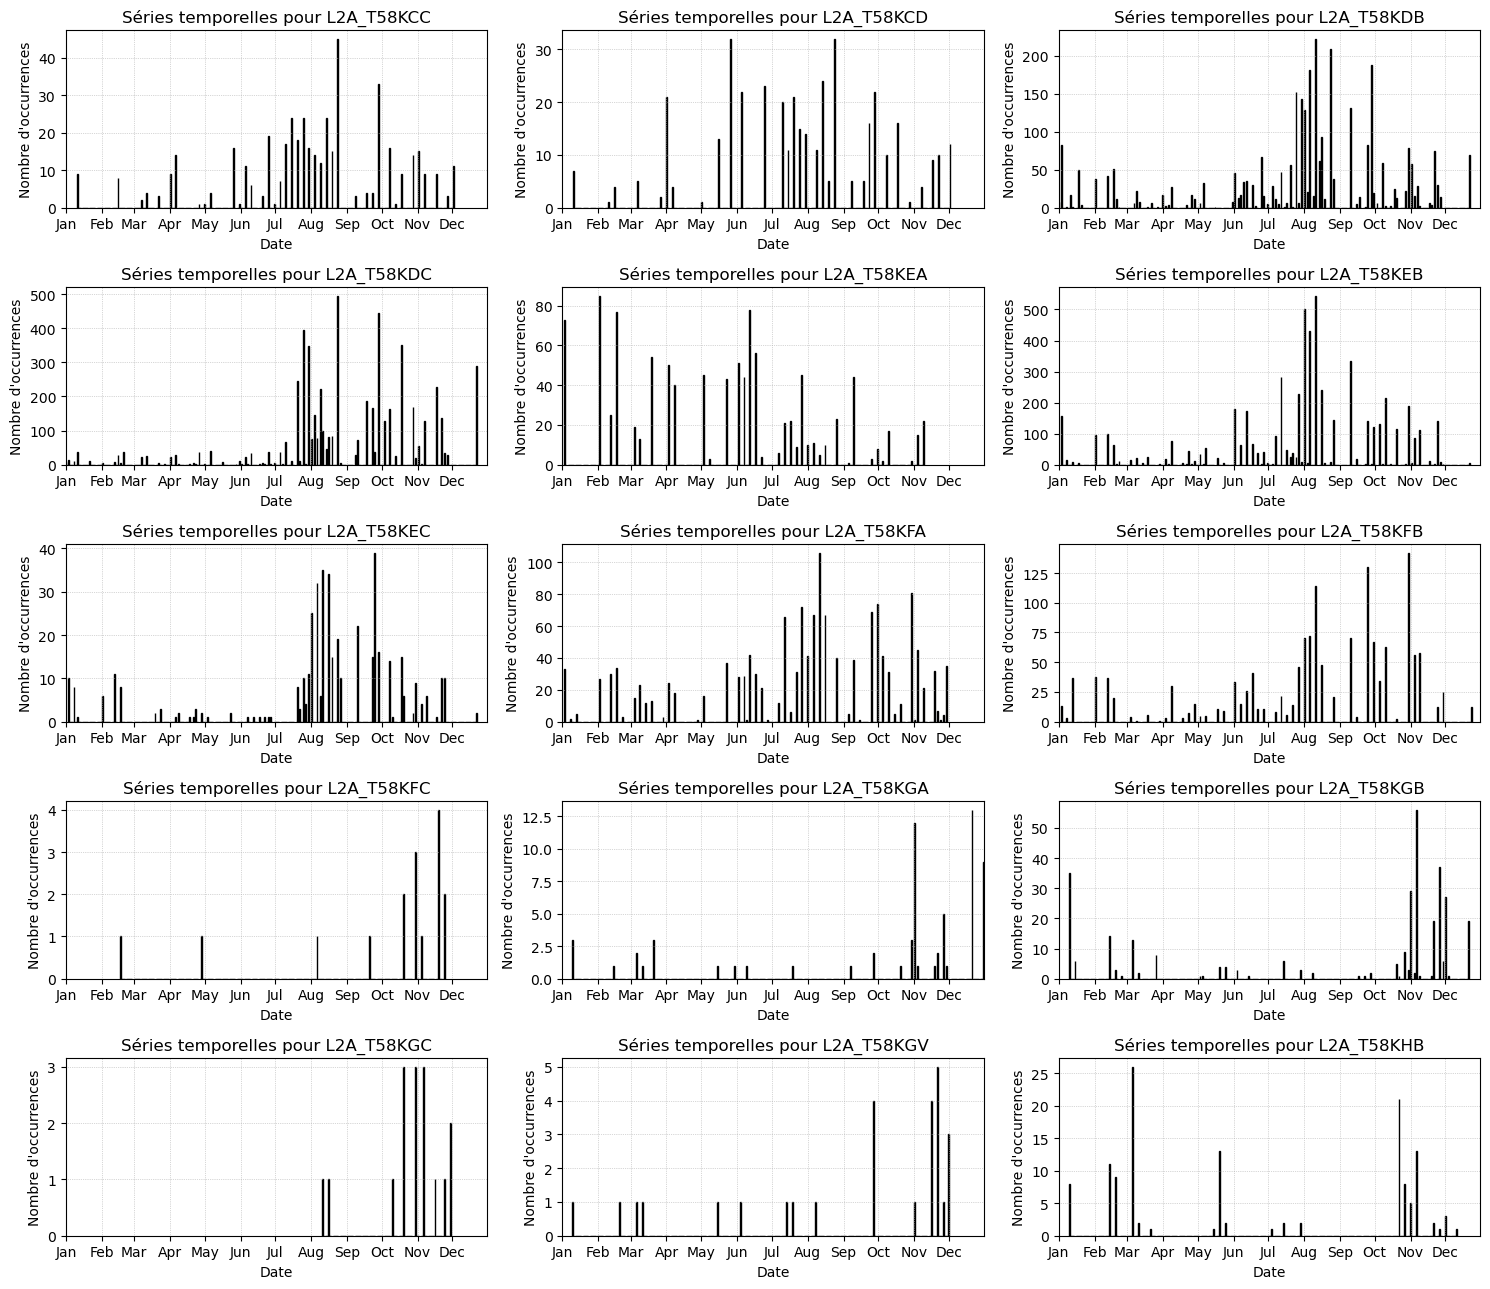

In [274]:
grouped = surfdetect_control.groupby('nom')
date_start=pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_end=pd.to_datetime("2023-12-31", format="%Y-%m-%d")

fig, axs = plt.subplots(nrows=5,ncols=3, figsize=(15, 13))
for i, (name, group_df) in enumerate(grouped):
    group_df['date'] = pd.to_datetime(group_df['date'])
    date_counts = group_df.resample('D').size()
    
    row_idx, col_idx = divmod(i, 3)
    
    axs[row_idx, col_idx].bar(date_counts.index, date_counts.values, width=0.8, align='center', color='blue', edgecolor='black')
    axs[row_idx, col_idx].set_title(f'Séries temporelles pour {name}')
    axs[row_idx, col_idx].set_xlabel('Date')
    axs[row_idx, col_idx].set_ylabel('Nombre d\'occurrences')
    axs[row_idx, col_idx].set_xlim(date_start, date_end)
    axs[row_idx, col_idx].xaxis.set_major_locator(MonthLocator())
    axs[row_idx, col_idx].xaxis.set_major_formatter(DateFormatter('%b'))
    axs[row_idx, col_idx].grid(True, which='both', linestyle=':', linewidth='0.5')

plt.tight_layout()
plt.show()

### Extract cloud cover from STAC Catalog

In [205]:
from pystac_client import Client
catalog = Client.open("https://earth-search.aws.element84.com/v1")
query = catalog.search(
    collections=["sentinel-2-l2a"],datetime="2023-05-01/2023-05-31", bbox=[163.362, -22.76, 168.223, -19.479]
)

In [211]:
from sentinelhub import SHConfig

config = SHConfig()
config.instance_id = "stac"
config.sh_client_id = '713157aa-ecbb-44fe-a8e6-e6e0af3eb968'
config.sh_client_secret = 'VGwoQEb8ye3aQWl1K03WFDjai3qae0kY'
config.save("my-profile")

catalog = SentinelHubCatalog(config=config)

catalog.get_info()
collections = catalog.get_collections()

collections = [collection for collection in collections if not collection["id"].startswith(("byoc", "batch"))]

In [300]:
caspian_sea_bbox = BBox((163.362, -22.76, 168.223, -19.479), crs=CRS.WGS84)
time_interval = "2023-01-01", "2023-12-31"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=caspian_sea_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Total number of results: 3618


[{'id': 'S2A_MSIL2A_20231231T230021_N0510_R058_T58KFV_20240101T005550',
  'properties': {'datetime': '2023-12-31T23:02:46Z', 'eo:cloud_cover': 19.93}},
 {'id': 'S2A_MSIL2A_20231231T230021_N0510_R058_T58KGV_20240101T005550',
  'properties': {'datetime': '2023-12-31T23:02:42Z', 'eo:cloud_cover': 33.85}},
 {'id': 'S2A_MSIL2A_20231231T230021_N0510_R058_T58KHV_20240101T005550',
  'properties': {'datetime': '2023-12-31T23:02:38Z', 'eo:cloud_cover': 14.35}},
 {'id': 'S2A_MSIL2A_20231231T230021_N0510_R058_T59KKQ_20240101T005550',
  'properties': {'datetime': '2023-12-31T23:02:38Z', 'eo:cloud_cover': 10.57}},
 {'id': 'S2A_MSIL2A_20231231T230021_N0510_R058_T58KFA_20240101T005550',
  'properties': {'datetime': '2023-12-31T23:02:33Z', 'eo:cloud_cover': 7.67}},
 {'id': 'S2A_MSIL2A_20231231T230021_N0510_R058_T58KGA_20240101T005550',
  'properties': {'datetime': '2023-12-31T23:02:28Z', 'eo:cloud_cover': 1.08}},
 {'id': 'S2A_MSIL2A_20231231T230021_N0510_R058_T58KHA_20240101T005550',
  'properties': {'

In [308]:
df = pd.json_normalize(results)
df = df.rename(columns={
    'id': 'ID',
    'properties.datetime': 'Date',
    'properties.eo:cloud_cover': 'Cloud_Cover'
})

df['ID'] = [x[39:-16] for x in df['ID']]
included_names = ['58KDB', '58KDC','58KEB','58KFA']
df = df[df['ID'].isin(included_names)]

replacements = {'58KDB': 'L2A_T58KDB', '58KDC': 'L2A_T58KDC', '58KEB': 'L2A_T58KEB','58KFA':'L2A_T58KFA'}
df.replace(replacements, inplace=True)
df=df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Extraire la partie date (année, mois, jour) en format YYY-MM-DD
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

C:\Users\oriane.bruyere\AppData\Local\Temp\ipykernel_23788\3578657624.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(replacements, inplace=True)


#### Zoom on famous tiles

c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\oriane.bruyere\AppData\Local\Temp\ipykernel_23788\3689545168.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter=axs[row_idx, col_idx].scatter(cc_group.Date,array_50,c=colors,vmin=0,vmax=100, s=600,marker='|',linewidth=2)
c:\Users\oriane.bruyere\AppData\Local\miniconda3\envs\gis39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

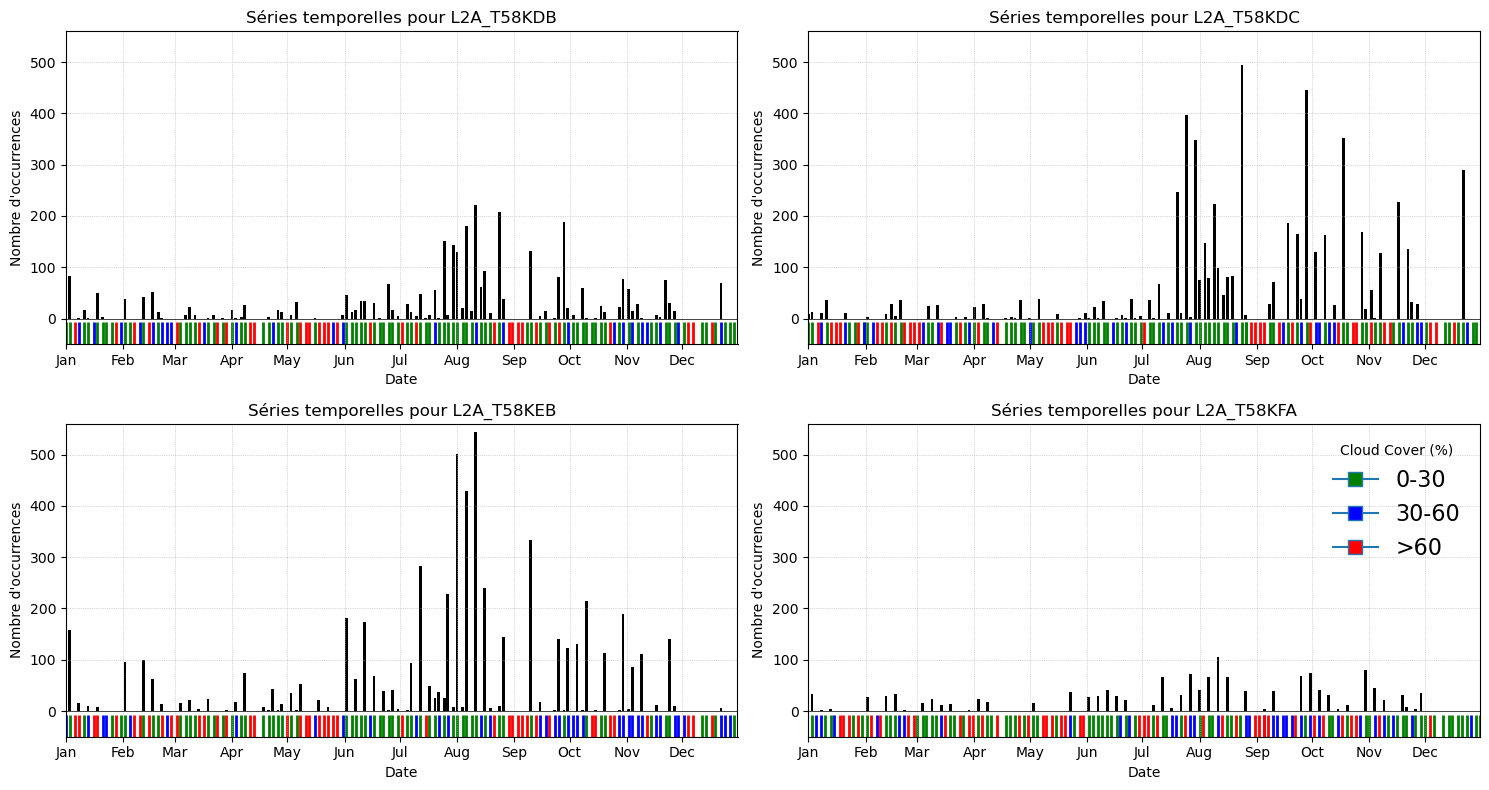

In [330]:
included_names = ['L2A_T58KDB', 'L2A_T58KDC','L2A_T58KEB','L2A_T58KFA']
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
custom_cmap = mcolors.ListedColormap(['green', 'blue', 'red'])

fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(15, 8))
for i, name in enumerate(included_names):
    cc_group = df.groupby('ID')

    if name in grouped.groups:
        group_df = grouped.get_group(name)
        cc_group = cc_group.get_group(name)

        group_df['date'] = pd.to_datetime(group_df['date'])
        date_counts = group_df.resample('D').size()
        row_idx, col_idx = divmod(i, 2)
        array_50 = np.full(len(cc_group.Date), -40)

        colors = np.zeros_like(cc_group.Cloud_Cover, dtype='str')
        colors[(cc_group.Cloud_Cover >= 0) & (cc_group.Cloud_Cover< 30)] = 'green'
        colors[(cc_group.Cloud_Cover >= 30) & (cc_group.Cloud_Cover < 60)] = 'blue'
        colors[cc_group.Cloud_Cover >= 60] = 'red'

        axs[row_idx, col_idx].axhline(y=0,lw=0.5,c='k')
        axs[row_idx, col_idx].bar(date_counts.index, date_counts.values, width=1.5, align='center', color='k')
        scatter=axs[row_idx, col_idx].scatter(cc_group.Date,array_50,c=colors,vmin=0,vmax=100, s=600,marker='|',linewidth=2)
        axs[row_idx, col_idx].set_title(f'Séries temporelles pour {name}')
        axs[row_idx, col_idx].set_xlabel('Date')
        axs[row_idx, col_idx].set_ylabel('Nombre d\'occurrences')
        axs[row_idx, col_idx].set_xlim(date_start, date_end)
        axs[row_idx, col_idx].xaxis.set_major_locator(MonthLocator())
        axs[row_idx, col_idx].xaxis.set_major_formatter(DateFormatter('%b'))
        axs[row_idx, col_idx].grid(True, which='both', linestyle=':', linewidth='0.5')
        axs[row_idx, col_idx].set_ylim(-50,550+10)

fake_handles = [plt.Line2D([0], [0], marker='s', markerfacecolor=color, markersize=10) for color in ['green', 'blue', 'red']]
legend = plt.legend(fake_handles, ['0-30', '30-60', '>60'], title='Cloud Cover (%)',fontsize=16, loc='upper right', frameon=False)

# Suppression du contour de la légende

plt.tight_layout()
plt.show()

## FINALISATION : Intégration des données dans la table "sentinel_surfaces_detectees"

In [ ]:
def IntegrationSurfacesSentinelGPK(s, inf, project_db_schema,data, name_regr, conn, filter_date, chmps_s, chmps_orig):
    data.to_postgis(name_regr,conn, schema=project_db_schema,if_exists='replace')
    sqlintegr = f"INSERT INTO {project_db_schema}.{s} ({chmps_s}) " + \
        f"SELECT {chmps_orig} FROM {project_db_schema}.{name_regr}"
    conn.connect().execute(sqlintegr)
    #insertion via table informations sentinel des nouveux identifiants
    sql_upd_info = f"INSERT INTO {project_db_schema}.{inf} (ogc_fid_surface, date_) " + \
        f"SELECT ogc_fid, date_ from {project_db_schema}.{s} where date_ >= '{filter_date}'"
    conn.connect().execute(sql_upd_info)

In [ ]:
s = "sentinel_surfaces_detectees"
inf = "sentinel_informations_surfaces_detectees"
datetxtdb = "date_texte"
datedb = "date_"
dateorig = '"date"'
chps = "nom, province, commune, surface, x, y, cuirasse, cuira_area, bdtopo, bdtop_area, geometry"
champs_s = f'{datetxtdb}, {chps}, {datedb}'
format_date_to_timestamp = 'YYYYMMDD'
champs_s_orig = f"{dateorig}, {chps}, to_timestamp({dateorig}, '{format_date_to_timestamp}')"
filt_date = '2023-1-1'
name_couche_temp="sentinel_surfaces_detectees_2023"

In [ ]:
conex = create_engine(f'postgresql://{os.getenv("DB_USER")}:{os.getenv("DB_PWD")}@{os.getenv("DB_HOST")}:{os.getenv("DB_PORT")}/{os.getenv("DB_WORKSPACE")}')
IntegrationSurfacesSentinelGPK(s, inf, os.getenv("DB_SCHEMA"),surfdetect_control , name_couche_temp, conex, filt_date, champs_s, champs_s_orig)
conex.dispose()